### OpenAI CliffWalking-v0 (Value Iteration and Policy Iteration)

Following code demonstrates the standard dynamic programming approaches of Policy Iteration and Value Iteration to solve the openAI Cliffwalking environment.

##### Importing Helper Libraries 

In [71]:
import gymnasium as gym         # generates the environment
import numpy as np             
import matplotlib.pyplot as plt # for generating plots
from IPython import display
from matplotlib import animation
from IPython.display import  HTML
%matplotlib inline

In [72]:
environment = 'CliffWalking-v0'
renderMode = 'rgb_array'
# action mapping 
actions = {0:'UP', 1:'RIGHT', 2:'DOWN', 3:'LEFT'}

#### Plotting the episodes

In [73]:
def simulate(env, policy,filename="sample.gif"):
    renders = []
    s = env.reset()[0]
    env.render()
    for t in range(100):
        a = policy[s]
        s_prime, r, done, truncated ,info = env.step(a)
        renders.append(env.render())
        s = s_prime
        if done:
            break
    fig = plt.figure()
    plt.axis("off")
    ims = [[plt.imshow(render, animated=True)] for render in renders]
    ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())
    # save the animation as a gif
    ani.save(filename, writer='imagemagick', fps=2)

##### Agent


In [74]:
# A generalised agent class that acts as parent class to the multiple agent classes, 
# that act and behave differently in the environment.
class Agent:

    def __init__(self,discountFactor = 0.99) -> None:
        # this initialises the environment
        self.env = gym.make(environment,
                            render_mode = renderMode)
        self.env.reset()
        self.returns = np.array([]) # initialise the returns array
        self.state_values = np.zeros(self.env.observation_space.n) # initialise the state values to zero
        self.discountFactor = discountFactor # discount factor

##### Confused Agent

In [75]:
class ConfusedAgent(Agent):
    # This agent picks up random actions sampled from the action space 
    def __init__(self) -> None:
        super().__init__()
        self.iterations = 100
        self.timesteps = 100
    
    def policy(self,env):
        return env.action_space.sample() # samples a random action from the action space
    
    def act(self):
        
        self.env = gym.make(environment,render_mode = renderMode)
        observation, info = self.env.reset()

        for _ in range(self.iterations): # iterate over the number of episodes

            r = 0 
            tt = 0
            for t in range(self.timesteps): # iterate over the number of timesteps
                action = self.policy(self.env)
                observation, reward, terminated, truncated,info = self.env.step(action)
                tt = t+1
                r += reward
                if terminated:
                    observation, info  = self.env.reset()
                    break
            reward = r/tt
            self.returns = np.append(self.returns, reward) # store the returns
        self.env.close()    


In [76]:
# sample run of the ConfusedAgent
confusedAgent = ConfusedAgent()
confusedAgent.act()
print("Average return of the ConfusedAgent is: ",np.mean(confusedAgent.returns))


Average return of the ConfusedAgent is:  -9.782310204081632


##### Policy Iteration

In [77]:
class PolicyIterationAgent(Agent):

    def __init__(self,discountFactor) -> None:
        
        super().__init__(discountFactor) # initialise the Agent class

    def PolicyEvaluation(self,policy,threshold = 1e-5)->bool:
        
        env = self.env                      # initialise the environment variable
        n = env.observation_space.n         # the number of states 
        state_values = self.state_values    # initialise the state values 
        discountFactor = self.discountFactor # discount factor
        delta = 0   
        valueConverged = False 
        updatedStateValues = state_values.copy()

        # iterate over all the states 
        for state in range(n-1):
            # do not iterate over the goal state
            # episode terminates at the goal state
            stateValue = 0
            action = policy[state] # the policy is discrete, get the action
            transitionProbabilities = env.P[state][action] # get the transition probabilities for the given state and action

            # expected return 
            for probability, nextState, reward, done in transitionProbabilities:
                expected_return =  probability *(reward + discountFactor * updatedStateValues[nextState])
                stateValue += expected_return
            
            delta = max(delta, abs(stateValue - updatedStateValues[state])) # update the delta
            updatedStateValues[state] = stateValue

        if delta < threshold: # check if the value function has converged
            valueConverged = True          
        
        self.state_values = updatedStateValues # update the state values
 
        return valueConverged
    
    def PolicyImprovement(self,policy)->bool:

        stop = True
        env = self.env
        n = env.observation_space.n
        discountFactor = self.discountFactor
        state_values = self.state_values

        # iterate over all the states except the goal state
        for state in range(n-1):
            bestAction = 0
            bestValue = -np.inf
            # iterate over all the actions, and find the best action
            for a in range(env.action_space.n):
                stateValue = 0
                transitionProbabilities = env.P[state][a]
                # expected return
                for probability, nextState, reward, done in transitionProbabilities:
                    expected_return =  probability *(reward + discountFactor * state_values[nextState])
                    stateValue += expected_return
                
                if stateValue > bestValue:
                    bestValue = stateValue
                    bestAction = a

            # check if the policy has converged
            if policy[state] != bestAction:
                stop = False
                policy[state] = bestAction
        
        self.returns = np.append(self.returns,state_values[36])
        return stop



    def Run(self):

        n = self.env.observation_space.n # the number of states
        policy = np.zeros(n,dtype = int) # initialise the policy to zero

        stop = False
        # iter = 0
        while not stop:
            # iter += 1
            # print(f'Iteration: {iter}') 
            # run Policy Evaluation           
            ValueConverged = False
            # i = 0         
            while not ValueConverged:
                # i += 1
                ValueConverged = self.PolicyEvaluation(policy) # run policy evaluation
                # print(f'Policy Evaluation: {i}')
            stop = self.PolicyImprovement(policy) # run policy improvement

        
        return policy, self.state_values # return the policy and the state values

Policy: 
 [['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'R' 'U']]
Expected Return:  -7.458134171671


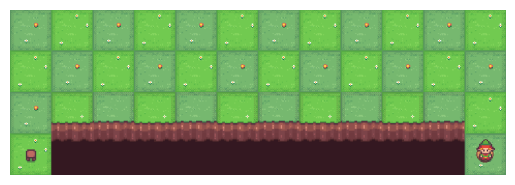

In [78]:
# sample run of Policy Iteration Agent
policyIterationAgent = PolicyIterationAgent(discountFactor=0.9)
policy, state_values = policyIterationAgent.Run()
simulate(policyIterationAgent.env,policy)
policy = policy.reshape(4,12)
policy = np.where(policy == 0, 'U', policy)
policy = np.where(policy == '1', 'R', policy)
policy = np.where(policy == '2', 'D', policy)
policy = np.where(policy == '3', 'L', policy)
print('Policy: \n', policy)
print('Expected Return: ',state_values[36]) # the expected return at the goal state

##### Value Iteration

In [79]:
class ValueIteration(Agent):
    
    def __init__(self,discountFactor) -> None:
        super().__init__(discountFactor)
        self.policy = np.zeros(self.env.observation_space.n,dtype = int)
         
    def ValueIteration(self,threshold = 1e-5)->bool:

        state_values = self.state_values

        n = self.env.observation_space.n

        stop = True
        delta = 0
        for state in range(n-1):
            bestValue = -np.inf
            
            for action in range(self.env.action_space.n):
                stateValue = 0
                transitionProbabilities = self.env.P[state][action]
                for probability, nextState, reward, done in transitionProbabilities:
                    expected_return =  probability *(reward + self.discountFactor * state_values[nextState])
                    stateValue += expected_return
                
                if stateValue > bestValue:
                    bestValue = stateValue
                    self.policy[state] = action
            
            delta = max(delta, abs(bestValue - state_values[state]))
            state_values[state] = bestValue
        
        self.state_values = state_values
        # average return of value iteration is the average of the start state value 
        self.returns = np.append(self.returns,state_values[36])
        return delta < threshold

    def Run(self):

        stop = False

        while not stop:
            stop = self.ValueIteration()
        
        return self.policy, self.state_values

In [80]:
# sample run of Value Iteration Agent
valueIteration = ValueIteration(discountFactor=0.9)
policy, state_values = valueIteration.Run()
print('Policy: \n')
policy = policy.reshape(4,12)
policy = np.where(policy == 0, 'U', policy)
policy = np.where(policy == '1', 'R', policy)
policy = np.where(policy == '2', 'D', policy)
policy = np.where(policy == '3', 'L', policy)
print(policy)
print('Expected Return : ',state_values[36])

Policy: 

[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'R' 'U']]
Expected Return :  -7.458134171671


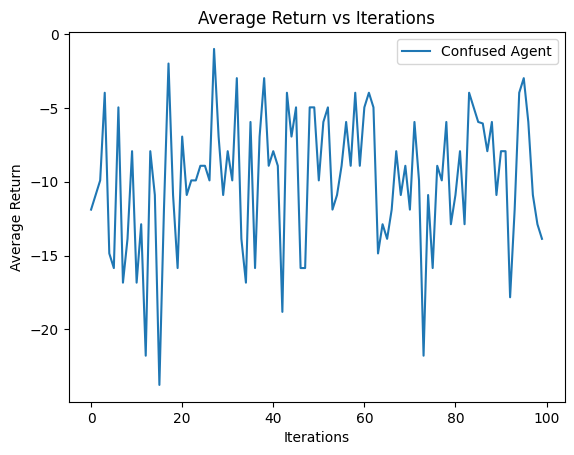

In [81]:
# plot the average returns of the confused agent 
plt.plot(confusedAgent.returns, label = 'Confused Agent')
# plot the average returns of the policy iteration agent
plt.xlabel('Iterations')
plt.ylabel('Average Return')
plt.title('Average Return vs Iterations')
plt.legend()
plt.show()

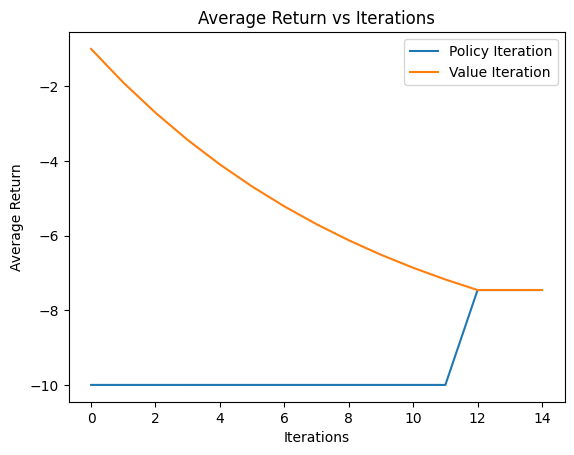

In [82]:
plt.plot(policyIterationAgent.returns, label = 'Policy Iteration')
plt.plot(valueIteration.returns, label = 'Value Iteration')
plt.xlabel('Iterations')
plt.title('Average Return vs Iterations')
plt.ylabel('Average Return')
plt.legend()
plt.show()


In [83]:
# generate plot for different discount factors 
discountFactorArrays = [0,0.1,0.5,0.75,0.99,1]
policyReturns = []
valueReturns = []
for discountFactor in discountFactorArrays:
    
    if discountFactor == 1: # it goes into an infinite loop
        policyIterationAgent = PolicyIterationAgent(discountFactor = 0.9999)
        policy, state_values = policyIterationAgent.Run()
        policyReturns.append(policyIterationAgent.returns)
    else: 
        policyIterationAgent = PolicyIterationAgent(discountFactor)
        policy, state_values = policyIterationAgent.Run()
        policyReturns.append(policyIterationAgent.returns)
    
    valueIteration = ValueIteration(discountFactor)
    policy, state_values = valueIteration.Run()
    valueReturns.append(valueIteration.returns)


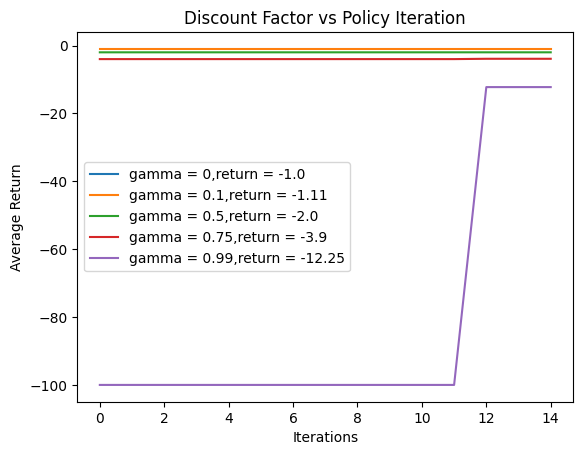

In [84]:
# plot for each gamma , policy iteration cumulative rewards vs iteration length
plt.plot(policyReturns[0], label = f'gamma = 0,return = {round(policyReturns[0][-1],2)}')
plt.plot(policyReturns[1], label = f'gamma = 0.1,return = {round(policyReturns[1][-1],2)}')
plt.plot(policyReturns[2], label = f'gamma = 0.5,return = {round(policyReturns[2][-1],2)}')
plt.plot(policyReturns[3], label = f'gamma = 0.75,return = {round(policyReturns[3][-1],2)}')
plt.plot(policyReturns[4], label = f'gamma = 0.99,return = {round(policyReturns[4][-1],2)}')
# plt.plot(policyReturns[5], label = f'gamma = 0.9999,return = {round(policyReturns[5][-1],2)}')
plt.title('Discount Factor vs Policy Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Return')
plt.legend()
plt.show()


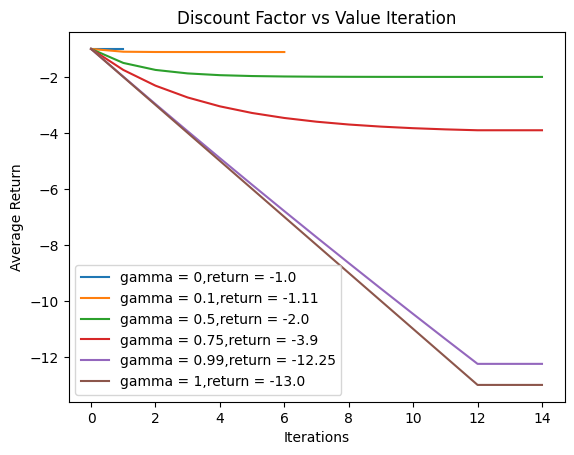

In [85]:

plt.plot(valueReturns[0], label = f'gamma = 0,return = {round(valueReturns[0][-1],2)}')
plt.plot(valueReturns[1], label = f'gamma = 0.1,return = {round(valueReturns[1][-1],2)}')
plt.plot(valueReturns[2], label = f'gamma = 0.5,return = {round(valueReturns[2][-1],2)}')
plt.plot(valueReturns[3], label = f'gamma = 0.75,return = {round(valueReturns[3][-1],2)}')
plt.plot(valueReturns[4], label = f'gamma = 0.99,return = {round(valueReturns[4][-1],2)}')
plt.plot(valueReturns[5], label = f'gamma = 1,return = {round(valueReturns[5][-1],2)}')
plt.title('Discount Factor vs Value Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Return')
plt.legend()
plt.show()


## Discount Factor 

Discount factor is a hyperparameter such that, it controls the amount of importance given to the actual present rewards vs the future reward. A higher value suggests, a greater value to the future rewards, while a low value suggests higher importance to the present rewards.

As we can see in the following cases, 


As we increase the value of discount factor, thus the agent prioritises current reward ( at low discount factor values ) is around **-9**, and thus avoids falling into the cliff, rather than reaching the final goal state, implied by a lower negative reward. Whereas, a higher discount factor, makes the agent to reach the goal state, and thus a higher negative reward **-13**.
